# Making Dotplots with Python

<b>Dotplots</b> are abundant on the AP Statistics exam, for a variety of reasons. Primarily, they're a great way to build a visualization of a distribution by hand, focusing one point on a time, without really needing to know what the next point is. You can eyeball the dataset to find a maximum and minimum, draw part of a number line (giving yourself the option to expand it), then go through the numbers in the dataset one-by-one, marking off observations as they are added to the number line. The height of each stack of dots increases as you go through more observations, but each observation gets its own standalone mark, so there is a one-to-one correspondence with items in the data set and dots on the dotplot. Obviously, dot plots are best with small datasets.

Contrast this with a histogram, which requires you to count all observations in a particular class to determine the height of a bar. I have definitely seen students waste time trying to make a "perfect" histogram––thinking they will be graded on something as trivial as whether or not they drew the bars with a ruler––when they should be diving into their analysis of the distribution.

Python libraries like matplotlib (which we will be using here), web apps like Google Sheets, and built-in functionality of graphing calculators make it incredibly easy to produce histograms, but there is a disconnect between the way we typically examine distributions when we have a computer (histograms) and the way students are taught to analyze distributions when working by hand (dotplots).

This creates an interesting problem for teachers (at least, it did for me): when I'm making assignments for class, is there a way for me to quickly make a dotplot, without having to do it by hand?

The purpose of this notebook is to provide a simple Python function for making dotplots from a one-dimensional array of numerical data. To keep the code clean and simple for students to follow along (in cases where teachers may want to integrate Python into their curriculum), we will be doing everything from scratch––with the exception of the plotting itself, which will make use of `pyplot`'s `scatter` function, and calling a small collection of built-in python functions, like `len`, `max` and `min`.

## The Algorithm

To make this as easy to use as possible, we're going to whittle down our inputs to two parameters:

* `data`: a list of real numbers
* `num_stacks`: the number of stacks to include in the dotplot
* `keys`: an optional parameter, where the user specifically includes the keys to be used.

First, we'll pass `data` to both `max` and `min`, in order to find the largest and smallest values in the dataset.

Next, we'll create a list of `stack_keys`. This list will consist of `num_stacks` evenly-spaced values starting at the minimum value and ending at the maximum value. These stacks represent values on the number line where we will make our stacks of dots. If the user specifies a list for `keys`, this is completely skipped.

After creating the list of `stack_keys`, we will assign each point to the largest `stack_key` value that is not greater than that individual observation. We will accomplish this with a dictionary, where the keys are the `stack_keys` and the values are lists containing data points that are greater than or equal to that `stack_key`.

Once we have our dictionary, we will compute the tallest stack. Having this value will allow us to scale our dotplot appropriately.

Once we have this stack, we're going to create a list of points to put on a scatter plot. We'll do this by letting each `stack_key` be an x-value, and assigning a y-value based on how many values there should be on that stack.

For example, if we have `data = [1, 2, 2, 3, 3, 5]` and three stacks, we would like to create the following dictionary of values:

```
{1:[1, 2, 2], 
 3:[3, 3], 
 5:[5]}
```

Three points should go above 1, two points should go above 3, and one point should go above 5. The cartesian coordinates of these points are:

(1,1), (1,2), (1,3) (three points over x=1)

(3,1), (3,2) (two points over x=3)

(5,1) (one point over x=5)

Then we'll plot these using `matplotlib.pyplot.scatter`, along with the following options:

1. Hiding the y-axis.
2. Hiding the left, top, and right spines.
3. Only including tick marks for the keys.
4. Giving a keyword argument for rotation, in case it's necessary.

## `get_stack_keys`

To start us out, we'll make a function called `get_stack_keys` which takes our data and the desired number of stacks and generates the points on the number line where we will build our stacks.

In practice, it's smarter to do this with 

```
numpy.linspace(start=minimum, 
               stop=maximum, 
               num=num_stacks,
               endpoint=True)
```

but this function is included to show the logic of creating an arbitrary number of evenly-spaced points between two values on the number line.

In [160]:
def get_stack_keys(data, num_stacks=5):
    """Creates a list containing the values where we will build our stacks.
    
    Returns an evenly-spaced list of real values of length num_stacks between 
    lower_bound and upper_bound (the minimum and maximum values  in data, 
    respectively).
    
    Because we want to include the upper_bound, we need to space the remaining 
    values range / (num_stacks - 1) units apart from each other.
    
    ================================================================================
    Parameters
    ----------
        data (list-like):
            A list of real numbers. This is the raw data we are exploring.
        num_stacks (int):
            The number of stacks we want to build on our dotplot. Must be a whole
            number greater than 1. Default value is 5.
    
    Returns
    -------
    A list of real values where we want to place our stacks.
    ================================================================================
    """
    upper_bound = max(data)
    lower_bound = min(data)
    stack_keys = [lower_bound + i * (upper_bound - lower_bound) / (num_stacks-1) 
              for i in range(num_stacks)]
    return stack_keys

assert get_stack_keys([1,2,3,4,5], 5) == [1.0, 2.0, 3.0, 4.0, 5.0]

## `get_stack_dict`

Now that we have a function for generating our `stack_keys`, we can build the actual stacks. 

To do this, we will create a dictionary of empty lists, where each key is a `stack_key`. Next, we'll iterate over the list of `stack_keys`, and when we find the two `stack_keys` that fall on either side of our value, we'll add the value to the list of values corresponding to that `stack_key`. As an example:

Suppose `data = [1,1,3,5,2]` and `num_stacks = 3`.

We get the list `[1, 3, 5]` from the call to `get_stack_keys`, we want the following dictionary:

`{1.0:[1,1,2], 3.0:[3], 5.0:[5]}`

Retaining the actual values from `data` will give us a bit more stylistic flexibility down the line. An alternative approach is simply letting the values be a counter for the number of observations that fall onto that stack.

There are several ways to do this. First, we'll look at a version that's easy to implement, but not particularly efficient. Next, we'll look at a way to compute it which is less intuitive to understand (and may not be quite as accessible at the high school level), but requires a little bit more problem-solving and could be used as a level-up for advanced students.

In [162]:
def get_stack_dict(data, num_stacks=5, keys=None):
    """Assigns each observation to the appropriate stack.
    
    Creates a dictionary of lists, where each key is a stack_key, then
    adds observations to the list corresponding to the correct stack.
    
    ================================================================================
    Parameters
    ----------
        data (list-like):
            A list of real numbers. This is the raw data we are exploring.
        num_stacks (int):
            The number of stacks we want to build on our dotplot. Must be a whole
            number greater than 1. Default value is 5.
        keys (list-like):
            Particular values to use for the keys. This can create more attractive
            dotplots, but depends on the user including evenly-spaced keys.
    
    Returns
    -------
    A dictionary, where the keys are stack_keys, and the value corresopnding to
    each key is a list of observations that fall on that stack.
    ================================================================================
    """
    if keys == None:
        keys = get_stack_keys(data=data, num_stacks=num_stacks)
    stack_dict = {key:[] for key in keys}
    
    for observation in data:        
        # a flag variable, indicating we need to add our value to the final
        # stack. by default, we assume we'll have to do this.
        add_to_end = True
        
        # step through the list, when observation is between two entries, add
        # it to the list corresponding to the key on the left. since we're 
        # comparing two adjacent list entries, we'll need to iterate over the 
        # index.
        for i in range(1, len(keys)):
            # if the observation is between these two keys
            if keys[i-1] <= observation < keys[i]:
                # add it to the lower key's list of values
                stack_dict[keys[i-1]].append(observation)
                
                # we don't need to add it to the end of the list
                add_to_end = False
                
                # we don't need to continue looking for the right key
                break
        
        # if we make it to the end of the list without finding the key to the
        # left of the value of the observation, that means we need to add it
        # to the final stack
        if add_to_end:
            stack_dict[keys[-1]].append(observation)
            
    # sanity check: does the sum of the length of each stack's list equal the
    #               number of observations in the original dataset?
    assert sum(len(stack_dict[key]) for key in stack_dict.keys()) == len(data)
        
    return stack_dict

assert get_stack_dict(data=[1,1,3,5,2], num_stacks=3) == {1.0:[1,1,2], 3.0:[3], 5.0:[5]}

## `get_points`

Now that we have a way to group our observations into bins, let's create a function for generating the corodinates of the points we want on our plot.

This function will iterate over the items in our dictionary and create a list of ordered pairs where the x-value is the `stack_key1`, and the y-value corresponds to the number of observations plotted above that `stack_key`.

In [66]:
def get_points(stack_dict):
    """Generates a list of points for the scatterplot based on the stack_dict.
    
    Iterates over the keys in stack_dict, and creates a list of points whose
    x-values are the keys, and whose y-values allow the points to stack over the
    desired x-value.
    
    ================================================================================
    Parameters
    ----------
        stack_dict (dict):
            a dictionary whose keys are the desired x-values for the dotplot, 
            and whose values are the number of observations falling on that stack.
    
    Returns
    -------
    A list of ordered pairs, representing points for the scatterplot to mimic a
    dotplot.
    ================================================================================
    """
    
    # the list to hold the points
    ordered_pairs = []
    
    # iterate over the items in the list
    for key, observations in stack_dict.items():
        
        # add a point onto the stack for each value in this list
        for i, obs in enumerate(observations):
            ordered_pairs.append((key, i+1))
    
    return ordered_pairs

get_points({1.0: [1, 1.4], 2.0: [2, 2], 3.0: [3, 3], 4.0: [], 5.0: [], 6.0: [], 7.0: [7]})

[(1.0, 1), (1.0, 2), (2.0, 1), (2.0, 2), (3.0, 1), (3.0, 2), (7.0, 1)]

## `dotplot`

And now we have everything we need to make our `dotplot` function! We'll it the data and tell it the number of stacks we want, and let the `dotplot` function handle the rest for us.

I've gone ahead and customized this code to produce the dotplots I always wanted, but the goal was to provide a minimal interface for teachers to create their own dotplots.

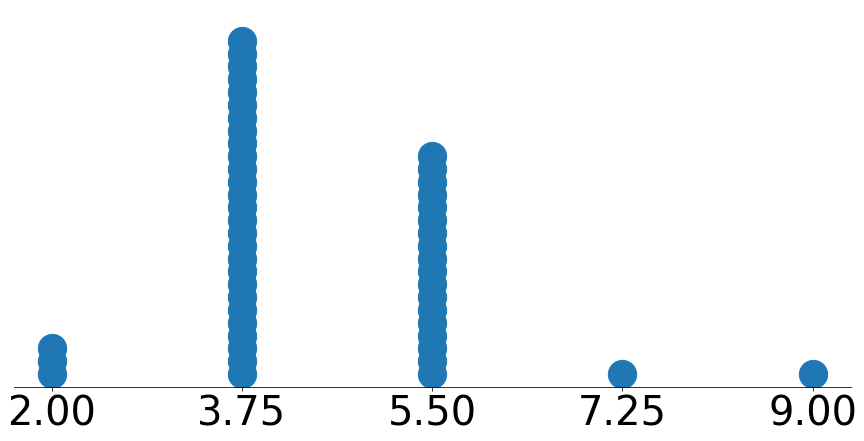

In [163]:
import matplotlib.pyplot as plt

def dotplot(data, num_stacks=5, keys=None, rotation=None, filename='image.png', show=False):
    """Function to create the dotplot and save it to a file.
    
    This function provides a minimal interface for creating a dotplot with 
    matplotlib. The smallest amount of information necessary to create the dotplot
    is a list of raw values for the data variable. For example:
    
        observations = [1,2,3,3,3,3,5,6,6,2,3,4,2,1,2]
        dotplot(data=observations)
        
    By default, this will create five stacks in the dotplot and save the file
    under the name 'image.png' in the working directory.
    ================================================================================
    Parameters
    ----------
        data (list-like):
            The list of observations (real numbers) to be plotted.
        num_stacks (int):
            The number of stacks to create in the dot plot.
            Default: 5
        keys (list):
            A list of real numbers indicating the specific locations for stacks on
            the x-axis.
            Default: None
        rotation (int):
            Degrees to rotate the labels on the x-axis. 45 is a good value if
            the keys are decimals longer than 3 places and you want to prevent 
            them from overlapping.
            Default: None
        filename (str):
            The name of the image.
            Default: 'image.png'
        
        show (bool):
            Whether or not to call plt.show(). If in a notebook, set show=True
            to show the dotplot inline.
            Default: False
    
    Returns
    -------
    None
    ================================================================================
    """
    
    # create the stack_dict
    stack_dict = get_stack_dict(data, num_stacks, keys)
    
    # get the keys (will return a list containing the same values if keys=None)
    keys = list(stack_dict.keys())
    
    # get the list of points
    points = get_points(stack_dict)
    
    # split the ordered pairs into x-values and y-values to make matplotlib happy
    xs = [x for x, _ in points]
    ys = [y for _, y in points]
    
    # create the figure
    plt.figure(figsize=(15,7))
    
    # plot the scatterplot
    plt.scatter(xs, ys, s=4000/len(keys))
    
    # turn off the y-axis
    plt.gca().get_yaxis().set_visible(False)
    
    # set the x-ticks
    plt.xticks(list(stack_dict.keys()), fontsize=200/num_stacks, rotation=rotation)
    
    # set the vertical limits
    plt.ylim(0, 1.1 * max(ys))
    
    # hide the box around the axis
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # save the file
    plt.savefig(filename)
    
    # show the figure, if possible
    if show:
        plt.show()